### Setup

In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import ElasticNet, LinearRegression, Lars, TweedieRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures, OneHotEncoder, PowerTransformer
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
import matplotlib.pyplot as plt
from vb_helper import VBHelper,shrinkBigKTransformer,logminus_T,exp_T,logminplus1_T,none_T, logp1_T,dropConst#,missingValHandler
from missing_val_transformer import missingValHandler
import os
import pandas as pd

In [2]:
import logging
logdir=os.path.join(os.getcwd(),'log'); 
if not os.path.exists(logdir):os.mkdir(logdir)
handlername=os.path.join(logdir,'vbflow.log')
logging.basicConfig(
    handlers=[logging.handlers.RotatingFileHandler(handlername, maxBytes=10**7, backupCount=100)],
    level=logging.DEBUG,
    format="[%(asctime)s] %(levelname)s [%(name)s.%(funcName)s:%(lineno)d] %(message)s",
    datefmt='%Y-%m-%dT%H:%M:%S')
logger = logging.getLogger(handlername)

In [3]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [4]:
try:
    import daal4py.sklearn
    daal4py.sklearn.patch_sklearn()
except:
    print('no daal4py')

no daal4py


In [5]:

from warnings import filterwarnings
filterwarnings('ignore')


In [6]:
test_share=0.1
cv_folds=5
cv_reps=5
cv_count=cv_folds*cv_reps
rs=1 # random_state for reproducibility
vbhelper=VBHelper(test_share,cv_folds,cv_reps,cv_count,rs)

##### Example Dataset

In [7]:
data_path=os.path.join('sample_data','ex1.csv')
df=pd.read_csv(data_path)
all_vars=list(df.columns)
print(all_vars)

['STA_ID', 'LONG', 'LAT', 'OrigHabCode', 'Date', 'THG_Fish', 'YEAR', 'SEASON', 'SUBAREA', 'HABCODE', 'Floc_Depth_ft', 'AFDW_Floc', 'MEHG_Floc', 'THG_floc', 'Tot_Phos_floc', 'Bulk_Dens_Floc', 'Soil_Thickness_FT', 'AFDW_Soil', 'Bulk_Dens_Soil', 'PH_soil', 'SO4_soil', 'MEHG_soil', 'THG_soil', 'Tot_Carbon_Soil_%', 'Tot_Nitrogen_Soil_%', 'Tot_Phos_soil', 'Wat_Depth_ft', 'COND_SW', 'DO_SW', 'TEMP_SW', 'PH_SW', 'TURB_SW', 'REDOX_SW', 'Alk_Phos_SW', 'CHLA_SW', 'CL_SW', 'MEHG_SW', 'NH4_SW', 'NO2_SW', 'NO3_SW', 'SO4_SW', 'Sol_Reac_Phos_SW', 'THG_SW', 'TOC_SW', 'Tot_Nitrogen_SW', 'Tot_Phos_SW', 'REDOX_PW', 'H2S_PW', 'Sol_Reac_Phos_PW', 'MEHG_Peri_AVG', 'THG_epi_peri']


In [8]:
y_name='THG_Fish'
loc_vars=['LAT','LONG']
drop_vars=['Date','OrigHabCode','STA_ID']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
x_vars=[var for var in all_vars if var not in drop_vars]
X_df=df.loc[:,x_vars]
y_df=df.loc[:,y_name]

In [9]:
include_intercept=1

In [10]:
if test_share:
     X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_share, random_state=rs)
else:
    X_train, X_test, y_train, y_test = (X_df, None, y_df, None)

In [11]:
n,k=X_train.shape

max_k=min([n//2,int(1.5*k)])

vbhelper.max_k=max_k

In [12]:
#set the strategy for handling missing values
mis_val_strat='impute_middle' 
#'impute_middle' uses the mean for numerical and most frequent for categorical.
# drop_row, impute_knn, impute_knn10

In [13]:
pre_process_regression_lars=lambda: Pipeline(steps=[
    ('prep',missingValHandler(strategy=mis_val_strat)),
    ('scale',StandardScaler()),
    ('dropc',dropConst()),
    ('shrink',shrinkBigKTransformer(max_k=max_k)),
    ('linreg',LinearRegression(fit_intercept=include_intercept))
])

In [14]:
model=pre_process_regression_lars()
model.fit(X_train,y_train)


Pipeline(steps=[('prep', missingValHandler(strategy='impute_middle')),
                ('scale', StandardScaler()), ('dropc', dropConst()),
                ('shrink', shrinkBigKTransformer(max_k=67, selector='Lars')),
                ('linreg', LinearRegression(fit_intercept=1))])

In [15]:
print(model.score(X_train,y_train))
model.score(X_train,y_train)


0.490332335954495


0.490332335954495

In [16]:
# use lambda to make a callable object for creating new models, but with args set already
# may be unnecessary due to sklearn cloning

gridpoints=3 # grid points for gridsearchcv param_grid 
linear_regression=lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),StandardScaler(),LinearRegression(fit_intercept=include_intercept)) 
linear_regression_lars=lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),StandardScaler(),shrinkBigKTransformer(max_k=max_k),LinearRegression(fit_intercept=include_intercept)) #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html

linear_svr =lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),StandardScaler(),LinearSVR(fit_intercept=include_intercept,random_state=rs,tol=1e-4,max_iter=10000,C=1))
rbf_svr=lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),StandardScaler(),SVR(kernel='rbf',tol=1e-4,max_iter=5000, C=1))
gradient_boosting_reg=lambda: make_pipeline(missingValHandler(strategy='pass-through'),HistGradientBoostingRegressor(max_iter=500))#,loss='poisson'))


linear_svr = Pipeline(steps=[('pre_processor',missingValHandler(strategy=mis_val_strat)),('scaler',StandardScaler()),('lin_svr',LinearSVR(random_state=0,tol=1e-4,max_iter=50000))])
lin_svr_param_grid={'lin_svr__C':np.logspace(-2,1,gridpoints)}
linear_svr_cv=lambda: GridSearchCV(linear_svr,param_grid=lin_svr_param_grid)

rbf_svr=Pipeline(steps=[('pre_processor',missingValHandler(strategy=mis_val_strat)),('scaler',StandardScaler()),('rbf_svr',SVR(kernel='rbf',tol=1e-4,max_iter=50000, cache_size=2*10**4))])
rbf_svr_param_grid={'rbf_svr__C':np.logspace(-2,2,gridpoints),'rbf_svr__gamma':np.logspace(-1,0.5,gridpoints)} 
rbf_svr_cv=lambda: GridSearchCV(rbf_svr,param_grid=rbf_svr_param_grid)


In [17]:


elastic_net =lambda: make_pipeline(missingValHandler(strategy=mis_val_strat),StandardScaler(), ElasticNet(fit_intercept=include_intercept,selection='random',tol=0.01,max_iter=500,warm_start=1))
enet_params={
    'elasticnet__alpha':np.logspace(-2,2,gridpoints),
    'elasticnet__l1_ratio':np.linspace(0,1,gridpoints)
}
elastic_net_cv=lambda: GridSearchCV(elastic_net(),param_grid=enet_params)#,scoring=search_scorer)

In [18]:
test=elastic_net_cv().fit(X_train,y_train)

In [19]:
test.score(X_test,y_test)

0.4921214614054489

In [20]:
transformer_list=[none_T(),logp1_T()]#[logminplus1_T(),none_T(),logminus_T()]#exp_T()] # imported...
lin_reg_y_t_pipe=Pipeline(steps=[('ttr',TransformedTargetRegressor(regressor=linear_regression_lars()))])
lin_reg_y_t_param_grid={
    'ttr__transformer':transformer_list,
    'ttr__regressor__shrinkbigktransformer__max_k':list(range(4,k,k//4))
}
lin_reg_y_transform=lambda: GridSearchCV(lin_reg_y_t_pipe,param_grid=lin_reg_y_t_param_grid)

In [21]:
#import pprint as pp

#pp.pprint(sorted(lin_reg_y_transform().get_params().keys()))
#pp.pprint(sorted(elastic_net_cv().get_params().keys()))

#### add PolynomialFeatures() to gridsearch
#### and try shrinking the number of parameters

In [22]:
steps=[
    ('prep',missingValHandler(strategy=mis_val_strat)),
    ('scaler',StandardScaler()),
    ('shrink_k1',shrinkBigKTransformer()), # retain a subset of the best original variables
    ('polyfeat',PolynomialFeatures(interaction_only=0)), # create interactions among them
    
    ('drop_constant',dropConst()),
    ('shrink_k2',shrinkBigKTransformer(selector=ElasticNet())), # pick from all of those options
    ('reg',LinearRegression(fit_intercept=include_intercept))]


X_T_pipe=Pipeline(steps=steps)
inner_cv=RepeatedKFold(n_splits=10, n_repeats=1, random_state=rs)
 

Y_T_X_T_pipe=Pipeline(steps=[('ttr',TransformedTargetRegressor(regressor=X_T_pipe))])
Y_T__param_grid={
    'ttr__transformer':transformer_list,
    'ttr__regressor__polyfeat__degree':[2],
    'ttr__regressor__shrink_k2__selector__alpha':np.logspace(-2,2,gridpoints),
    'ttr__regressor__shrink_k2__selector__l1_ratio':np.linspace(0,1,gridpoints),
    'ttr__regressor__shrink_k1__max_k':[k//4,k//2,k]
}
lin_reg_Xy_transform=lambda: GridSearchCV(Y_T_X_T_pipe,param_grid=Y_T__param_grid,cv=inner_cv,n_jobs=11)



In [23]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
search_scorer='r2'
cv=RepeatedKFold(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs) # define separately to ensure same cv data used for each model
vbhelper.scorer_list=scorer_list
# allow/generate water quality thresholds for stratified kfold sub-sampling to ensure cross-validation folds have full range of water quality

In [24]:
test2=lin_reg_Xy_transform().fit(X_train,y_train)
print(test2.score(X_train,y_train))
test2.score(X_test,y_test)

0.5184865554255349


0.5430192441345313

In [25]:
estimator_dict={
    #'linear-regression':linear_regression,
    #'linear-regression-lars':linear_regression_lars,
    'lin_reg_y_transform':lin_reg_y_transform,
    'lin_reg_Xy_transform':lin_reg_Xy_transform,
    'elastic-net':elastic_net_cv, 
    'linear-svr-cv':linear_svr_cv, 
    #'rbf-svr-cv':rbf_svr_cv, 
    'gradient-boosting-reg':gradient_boosting_reg
   }
vbhelper.estimator_dict=estimator_dict
model_dict={key:val() for key,val in estimator_dict.items()} # they will be models once .fit is called

In [26]:
i=0
for name,est in model_dict.items():
    i+=1;print(name)
    est.fit(X_train,y_train)
    print(est.score(X_test,y_test))


lin_reg_y_transform
0.48342581370738247
lin_reg_Xy_transform
0.5430192441345313
elastic-net
0.49021829113570525
linear-svr-cv
0.4113545178491558
gradient-boosting-reg
0.5080126523357364


In [27]:
cv_results={}
for estimator_name,model in model_dict.items():
    model_i=cross_validate(model, X_train, y_train, return_estimator=True, scoring=scorer_list, cv=cv, n_jobs=-1)
    print(f"{estimator_name},{[(scorer,np.mean(model_i[f'test_{scorer}'])) for scorer in scorer_list]}")
    cv_results[estimator_name]=model_i
            
# replace with a loop in order to save the residuals for a graph?

lin_reg_y_transform,[('neg_mean_squared_error', -7717.816511265371), ('neg_mean_absolute_error', -64.4418507066653), ('r2', 0.3981848390281797)]
lin_reg_Xy_transform,[('neg_mean_squared_error', -8938.950536936563), ('neg_mean_absolute_error', -66.51093374574269), ('r2', 0.3048749198020968)]
elastic-net,[('neg_mean_squared_error', -7674.384181229426), ('neg_mean_absolute_error', -64.52145107137773), ('r2', 0.4006688714973513)]
linear-svr-cv,[('neg_mean_squared_error', -8348.334223839562), ('neg_mean_absolute_error', -64.51267676245429), ('r2', 0.3484803880332217)]
gradient-boosting-reg,[('neg_mean_squared_error', -6894.108224143473), ('neg_mean_absolute_error', -58.41033824378424), ('r2', 0.461358269593706)]


### graphs and table to summarize results

In [28]:
cv_score_dict={}
cv_score_dict_means={}
for idx,(estimator_name,result) in enumerate(cv_results.items()):
    #cv_estimators=result['estimator']
    model_idx_scoredict={scorer:result[f'test_{scorer}'] for scorer in scorer_list}# fstring bc how cross_validate stores list of metrics
    cv_score_dict[estimator_name]=model_idx_scoredict 
    model_idx_mean_scores={scorer:np.mean(scores) for scorer,scores in model_idx_scoredict.items()}
    cv_score_dict_means[estimator_name]=model_idx_mean_scores

In [29]:
for scorer in scorer_list:
    print(f'scores for scorer: {scorer}:')
    for estimator_name in model_dict:
        print(f'    {estimator_name}:{cv_score_dict_means[estimator_name][scorer]}')

scores for scorer: neg_mean_squared_error:
    lin_reg_y_transform:-7717.816511265371
    lin_reg_Xy_transform:-8938.950536936563
    elastic-net:-7674.384181229426
    linear-svr-cv:-8348.334223839562
    gradient-boosting-reg:-6894.108224143473
scores for scorer: neg_mean_absolute_error:
    lin_reg_y_transform:-64.4418507066653
    lin_reg_Xy_transform:-66.51093374574269
    elastic-net:-64.52145107137773
    linear-svr-cv:-64.51267676245429
    gradient-boosting-reg:-58.41033824378424
scores for scorer: r2:
    lin_reg_y_transform:0.3981848390281797
    lin_reg_Xy_transform:0.3048749198020968
    elastic-net:0.4006688714973513
    linear-svr-cv:0.3484803880332217
    gradient-boosting-reg:0.461358269593706


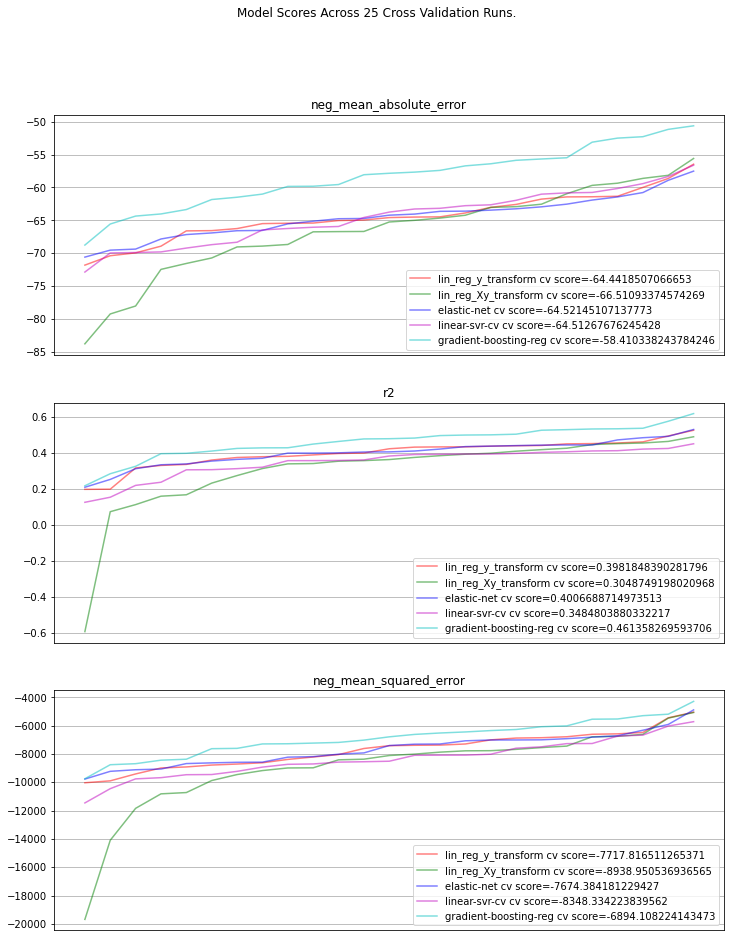

In [30]:
vbhelper.plotCVScores(cv_score_dict,sort=1)

In [31]:
# create a similar plot showing residuals from the cv models for each value of y. 
# needs to be scatterplot or histogram since there will be (folds-1)*repeats predictions of each value of y.

-----------------------------
### User chooses Linear Regression with LARS variable selection!


In [32]:
final_estimator_name='linear-regression-lars'

In [33]:
def printTestandCVScores(estimator_name,cv_score_dict_means):
    model=estimator_dict[estimator_name]()
    model.fit(X_train,y_train)
    if test_share:
        y_test_hat=model.predict(X_test)
        print(f'test set: negative-mse={-mean_squared_error(y_test,y_test_hat)}')
    for scorer in scorer_list:
        print(f'cv avg: {scorer}= {cv_score_dict_means[estimator_name][scorer]}')
    try:
        print('coefficients: ',model[-1].coef_)
        print('intercept: ',model[-1].intercept_)
        #print('\n','original positions: ',model[-2].col_select)
    except:
        pass

In [34]:
for name in estimator_dict.keys():
    print(name)
    printTestandCVScores(name,cv_score_dict_means)

lin_reg_y_transform
test set: negative-mse=-9801.964948670751
cv avg: neg_mean_squared_error= -7717.816511265371
cv avg: neg_mean_absolute_error= -64.4418507066653
cv avg: r2= 0.3981848390281797
lin_reg_Xy_transform
test set: negative-mse=-8671.183094451122
cv avg: neg_mean_squared_error= -8938.950536936563
cv avg: neg_mean_absolute_error= -66.51093374574269
cv avg: r2= 0.3048749198020968
elastic-net
test set: negative-mse=-9656.478564582174
cv avg: neg_mean_squared_error= -7674.384181229426
cv avg: neg_mean_absolute_error= -64.52145107137773
cv avg: r2= 0.4006688714973513
linear-svr-cv
test set: negative-mse=-11169.51356908797
cv avg: neg_mean_squared_error= -8348.334223839562
cv avg: neg_mean_absolute_error= -64.51267676245429
cv avg: r2= 0.3484803880332217
gradient-boosting-reg
test set: negative-mse=-9335.431124819872
cv avg: neg_mean_squared_error= -6894.108224143473
cv avg: neg_mean_absolute_error= -58.41033824378424
cv avg: r2= 0.461358269593706


In [35]:
printTestandCVScores('elastic-net',cv_score_dict_means)
# fits better but soooo many coefficients

test set: negative-mse=-9662.765530213475
cv avg: neg_mean_squared_error= -7674.384181229426
cv avg: neg_mean_absolute_error= -64.52145107137773
cv avg: r2= 0.4006688714973513


In [36]:
printTestandCVScores('lin_reg_Xy_transform',cv_score_dict_means)

test set: negative-mse=-8671.183094451122
cv avg: neg_mean_squared_error= -8938.950536936563
cv avg: neg_mean_absolute_error= -66.51093374574269
cv avg: r2= 0.3048749198020968
